* Authors: Jack Huey, Macrina Lobo

In [ ]:
import pandas as pd
import os
import re
import numpy as np

import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
great = pd.read_csv("GREATpicks_distal_elements_by_cluster.csv",header=None,squeeze=True)
great.head()

0    MP:0002085
1    MP:0002080
2    MP:0008762
3    MP:0010770
4    MP:0000428
Name: 0, dtype: object

In [3]:
great_terms = list(set(list(great)))
len(great_terms)

67

In [5]:
clusters = ["C18","C19","C21","C22","C13","C12","C10","C9","C11","C14","C15","C8","C3","C4","C5","C6","C7","C1","C2","C16","C17"]

In [32]:
cluster_colors = ['#485991','#2C575E','#C99C63','#3D3D3D','#E38578','#89C765','#D9C4DD','#C980B6','#8FD4DD','#AE81AD','#BF5D58','#9B8EC4','#217849','#6B4479','#CB5C51','#F9B314','#CCC759','#D51F26','#372C63','#8F2F25','#7B8B70','#5386A3']

In [6]:
term_types = ['Human_Phenotype','Mouse_Phenotype_Single_KO','Mouse_Phenotype',
              'GO_Cellular_Component','GO_Biological_Process','GO_Molecular_Function']

In [45]:
def read_terms(base_dir, prefix, clusters, cluster_colors, value='binom'):
    if value not in ['binom', 'hyper']:
        raise Error("Only `binom` or `hyper` allowed")

    term_mat = pd.DataFrame(np.zeros((len(clusters), len(great_terms))), index=clusters, columns=great_terms)
    
    print("Reading cluster data")
    id_name = {}
    for clus in clusters:
        for term in term_types:
            path = f"{base_dir}/{prefix}.{clus}.{term}.csv"
            if not os.path.exists(path):
                print(f"Skipping {path} because it is missing")
                continue
            tmp_info = pd.read_csv(path, index_col=0)
            index_colname = term.replace('_','.')
            tmp_info_trunc = tmp_info.loc[tmp_info[index_colname + '.ID'].isin(great_terms),[index_colname + '.ID',index_colname + '.name',index_colname + '.Binom_Adjp_BH',index_colname + '.Hyper_Adjp_BH']]
            tmp_info_trunc['logp_binom'] = -np.log10(tmp_info_trunc[index_colname + '.Binom_Adjp_BH'])
            tmp_info_trunc['logp_hyper'] = -np.log10(tmp_info_trunc[index_colname + '.Hyper_Adjp_BH'])

            # add to term_mat
            for found_term in tmp_info_trunc[index_colname + '.ID']:
                if  found_term not in id_name:
                    id_name[found_term]  =  found_term + '|' + list(tmp_info_trunc.loc[tmp_info_trunc[index_colname + '.ID']==found_term,index_colname + '.name'])[0]
                if value == 'binom':
                    term_mat.loc[clus,found_term] = list(tmp_info_trunc.loc[tmp_info_trunc[index_colname + '.ID']==found_term,'logp_binom'])[0]
                else:
                    term_mat.loc[clus,found_term] = list(tmp_info_trunc.loc[tmp_info_trunc[index_colname + '.ID']==found_term,'logp_hyper'])[0]

    term_mat.rename(columns=id_name, inplace=True)

    print("Reording rows")
    ordered_rows = []
    idx_max = term_mat.idxmax() 
    for entry in clusters:
        terms_found = list(idx_max[idx_max==entry].index)
        for entry2 in terms_found:
            if entry2 not in ordered_rows:
                ordered_rows.append(entry2)
    term_mat = term_mat[ordered_rows]

    print("Creating AnnData objects")
    adata = anndata.AnnData(X=term_mat)
    adata.obs['cluster'] = adata.obs.index.astype('category')
    adata.obs['cluster'] = adata.obs['cluster'].cat.reorder_categories(clusters)
    adata.uns['cluster_colors'] = cluster_colors

    sc.pl.heatmap(adata,figsize=(16,16),standard_scale='var',dendrogram=False,swap_axes=True,var_names=adata.var.index,groupby='cluster',show_gene_labels=True,save=f'_{base_dir}.pdf')

Reading cluster data
Reording rows
Creating AnnData objects


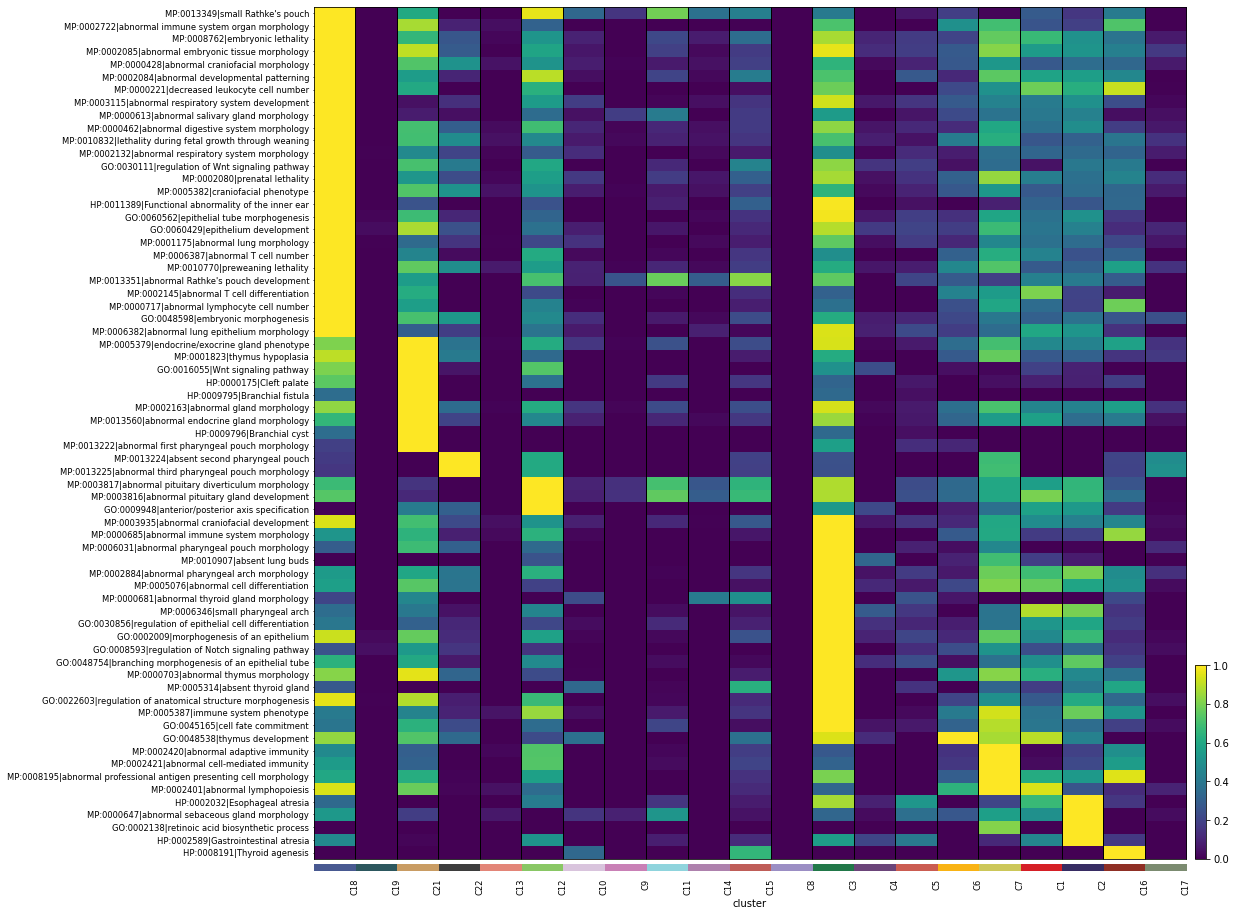

In [35]:
read_terms('cluster_conservation_euar_top', 'TableS3.conservation_euar.0_5.distal', clusters, cluster_colors)

In [120]:
# Cluster: [0, 0-0.5, 0.5-1]
counts = {}
with open('TableS3.conservation_euar.bed') as f:
    for line in f:
        cols = line.strip().split("\t")
        cluster = cols[7]
        conservation = float(cols[12])
        counts[cluster] = counts.get(cluster, [0, 0, 0])
        if conservation == 0:
            index = 0
        elif conservation <= 0.5:
            index = 1
        else:
            index = 2
        #index = int(np.ceil(conservation/0.50))
        counts[cluster][index] += 1

In [121]:
counts

{'C1': [12, 321, 67],
 'C2': [23, 759, 174],
 'C3': [123, 3393, 396],
 'C4': [15, 585, 101],
 'C5': [0, 164, 37],
 'C6': [28, 984, 109],
 'C7': [78, 2618, 269],
 'C8': [2, 32, 9],
 'C9': [3, 152, 31],
 'C10': [54, 1034, 79],
 'C11': [13, 530, 100],
 'C12': [105, 3438, 324],
 'C13': [8, 512, 89],
 'C14': [5, 127, 42],
 'C15': [11, 657, 176],
 'C16': [85, 4209, 259],
 'C17': [15, 1154, 146],
 'C18': [169, 7091, 694],
 'C19': [24, 794, 49],
 'C21': [54, 3175, 553],
 'C22': [25, 1542, 358]}

In [122]:
percent_counts = np.array([np.array((count_array := counts[c] )) /np.sum(np.array(count_array)) for c in clusters])
percent_counts

array([[0.02124717, 0.89150113, 0.0872517 ],
       [0.02768166, 0.91580161, 0.05651672],
       [0.01427816, 0.83950291, 0.14621893],
       [0.01298701, 0.80103896, 0.18597403],
       [0.01313629, 0.8407225 , 0.14614122],
       [0.02715283, 0.88906129, 0.08378588],
       [0.04627249, 0.88603256, 0.06769494],
       [0.01612903, 0.8172043 , 0.16666667],
       [0.02021773, 0.82426128, 0.155521  ],
       [0.02873563, 0.72988506, 0.24137931],
       [0.01303318, 0.77843602, 0.20853081],
       [0.04651163, 0.74418605, 0.20930233],
       [0.03144172, 0.86733129, 0.10122699],
       [0.021398  , 0.83452211, 0.14407989],
       [0.        , 0.8159204 , 0.1840796 ],
       [0.0249777 , 0.87778769, 0.09723461],
       [0.02630691, 0.88296796, 0.09072513],
       [0.03      , 0.8025    , 0.1675    ],
       [0.02405858, 0.79393305, 0.18200837],
       [0.01866901, 0.92444542, 0.05688557],
       [0.01140684, 0.87756654, 0.11102662]])

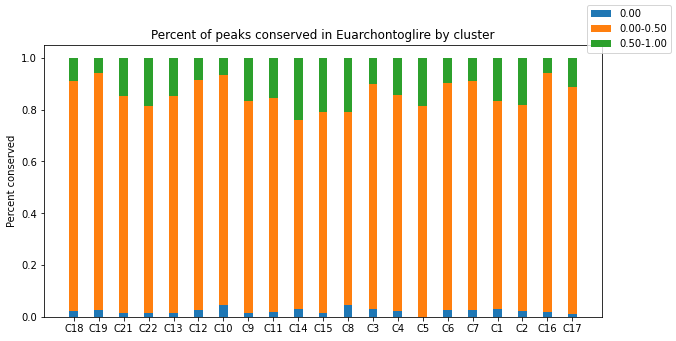

In [151]:
labels = clusters
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))

bar_counts = percent_counts
ax.bar(labels, bar_counts[:, 0], width, bottom=0, label='0.00')
ax.bar(labels, bar_counts[:, 1], width, bottom=np.cumsum(bar_counts, axis=1)[:, 0], label='0.00-0.50')
ax.bar(labels, bar_counts[:, 2], width, bottom=np.cumsum(bar_counts, axis=1)[:, 1], label='0.50-1.00')

ax.set_ylabel('Percent conserved')
ax.set_title('Percent of peaks conserved in Euarchontoglire by cluster')
fig.legend(ax.get_legend_handles_labels()[0], ('0.00', '0.00-0.50', '0.50-1.00'))
#ax.legend()

fig.savefig('figures/percent-conserved-euar-3split-with-0.pdf')

plt.show()